# Flood Image Classification Model · From Single Fixed Camera History

---

In [1]:
cd ../

C:\Users\luisr\Desktop\Repositories\Data Science Projects\Hackaton COR IV - Centro de Operações do RJ\INCUBAÇÃO\Cameras


#### General purpose parameters

In [2]:
random_state = 0 # seed for random generator
replacement = False

#### Import libraries

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB

c:\Users\luisr\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


#### Class to load frames from labeled videos as labeled images

In [4]:
import os, cv2, numpy as np
from IPython.display import clear_output as co

class FrameLoader:
        
    def __init__(self, dim=3):
        """  """
        self.dim = dim
        
    def frames_from_labeled_videos(self, paths, labels, print_each=None):
        i, n  = 0, max(len(paths), len(labels))
        x, y = [], []
        for path, label in zip(paths, labels):
            frames = self.frames_from_video(path)
            x += frames; y += [label] * len(frames)
            i += 1
            if print_each is not None and i % print_each == 0:
                co(True); print(f'CAPTURE LABELED VIDEOS · OPEN: {i}/{n}')
        return np.array(x), np.array(y)
        
    def frames_from_video(self, path):
        cap = cv2.VideoCapture(path)
        if not cap.isOpened():
            print(f"CANNOT OPEN VIDEO CAPTURE · PATH: {path}")
            return []
        frames = []
        while True:
            ret, frame = cap.read()
            if not ret:
                break # stream finished
            if self.dim == 1: # 1D flat frame
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                frame = np.reshape(frame, -1)
            if self.dim == 2: # 2D gray scale frame
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            frames.append(frame)
        cap.release(); cv2.destroyAllWindows()
        return frames

#### Function to display train and test classes counting

In [5]:
import pandas as pd

def split_class_count(y_train, y_test):
    display(pd.concat([
        pd.Series(y_train).value_counts().to_frame('Train set'),
        pd.Series(y_test).value_counts().to_frame('Test set')
    ], axis=1))

#### Function to display mislabeled images

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def display_mislabeled_images(X_test, y_test, y_pred, display_max=5, random=True, img_shape=(854, 480), n_cols=3):

    error_msk = y_test != y_pred
    n_mis = error_msk.sum()

    x_test_mis = X_test[error_msk]
    y_test_mis = y_test[error_msk]
    y_pred_mis = y_pred[error_msk]

    n_imgs = min(n_mis, display_max)

    index_show = list(range(n_imgs))
    if random:
        index_show = np.random.choice(index_show, size=n_imgs, replace=False)

    mis_samples = x_test_mis[index_show]
    mis_labels = y_test_mis.iloc[index_show]
    mis_preds = y_pred_mis[index_show]

    n_rows = n_imgs // n_cols + 1
    fig = plt.figure(figsize=(6 * n_cols, 4.5 * n_rows))
    axs = [fig.add_subplot(n_rows, n_cols, i) for i in range(1, n_imgs + 1)]

    for i, (xi, yi, ypi, tstamp) in enumerate(zip(mis_samples, mis_labels, mis_preds, mis_labels.index)):
        ax = axs[i]
        img_reshape = np.reshape(xi, tuple(reversed(img_shape)))
        ax.imshow(img_reshape)
        ax.set(title=f'{tstamp} · True: {yi} · Predicted: {ypi}')
        
    plt.show()

---
## Reload labeled flood videos dataset

In [7]:
import pandas as pd

videos = pd.read_csv('Dados/Rotulos/1475_2023-02-07.csv')

# preprocessing
videos['timestamp'] = pd.to_datetime(videos['timestamp'])
videos = videos.set_index('timestamp', drop=True).sort_index()

# drop videos larger than `video_max_bytes`
video_max_bytes = 5e6 # 5 Mb
videos = videos[videos['blob_size'] < video_max_bytes]

display(videos[['blob_name', 'tag']].head())
print(f'Shape: {videos.shape}')

mega_bytes = round(videos["blob_size"].sum() / 1e6, 3)
print(f'\nTotal video bytes: {mega_bytes} Mb')

,blob_name,tag
timestamp,,
2023-02-07 19:25:00,polygons/flood-unlabeled/1/1475/CODE1475 2023-...,alagamento
2023-02-07 19:30:00,polygons/flood-unlabeled/1/1475/CODE1475 2023-...,alagamento
2023-02-07 19:35:00,polygons/flood-unlabeled/1/1475/CODE1475 2023-...,alagamento
2023-02-07 19:40:00,polygons/flood-unlabeled/1/1475/CODE1475 2023-...,alagamento
2023-02-07 19:50:00,polygons/flood-unlabeled/1/1475/CODE1475 2023-...,alagamento


Shape: (163, 8)

Total video bytes: 139.203 Mb


---
## Video Data Preprocessing

#### Binarize videos class labels

In [10]:
replace_tags = {
    'acúmulo': ['lâmina', 'bolsão', 'alagamento'],
    'normalidade': ['poça', 'normalidade'],
}

y_true = []
for tag in videos['tag']:
    for key, values in replace_tags.items():
        if tag in values: y_true.append(key)

y_true = pd.Series(y_true, index=videos.index)

videos['label'] = y_true

display(videos['tag'].value_counts().to_frame('Video Tags'))
display(videos['label'].value_counts().to_frame('Video Binarized Labels'))

,Video Tags
tag,
normalidade,120
alagamento,26
poça,8
lâmina,6
bolsão,3


,Video Binarized Labels
label,
normalidade,128
acúmulo,35


---
## Optional · Video Data Sampling

#### Optional · Under sampling videos from majority class · Drop exceeding class members

In [12]:
from imblearn.under_sampling import RandomUnderSampler

sampling_strategy = 1.0

# Sampler instance
rus = RandomUnderSampler(sampling_strategy, random_state, replacement)
# Resample operation
x_res, y_res = rus.fit_resample(videos, y_true)

display(y_res.value_counts().to_frame('Videos Sub-sample'))

c:\Users\luisr\anaconda3\lib\site-packages\imblearn\utils\_validation.py:587: FutureWarning: Pass sampling_strategy=1.0, random_state=0, replacement=False as keyword args. From version 0.9 passing these as positional arguments will result in an error
  warnings.warn(


,Videos Sub-sample
acúmulo,35
normalidade,35


#### Optional · Train and test split of video samples

In [15]:
from sklearn.model_selection import train_test_split

t_size = 0.1  # 0.25 recommended after under-sample
e_size = 0.4  # 0.25 recommended after under-sample

# X, Y = x_res, y_res  # pre-sampled
X, Y = videos, y_true  # complete set of videos

xt, xe, yt, ye = train_test_split(
    X, Y, test_size=e_size, train_size=t_size,
    random_state=random_state, shuffle=True, stratify=Y
)

# complete x and y sequences
yy = pd.concat([yt, ye], axis=0)
xx = pd.concat([xt, xe], axis=0)

split_class_count(yt, ye)
display(yy.value_counts().to_frame('Video Samples'))

,Train set,Test set
normalidade,13,52
acúmulo,3,14


,Video Samples
normalidade,65
acúmulo,17


---
## Load images and class labels from selected labeled videos

In [ ]:
folder = 'Dados/flood-video-collection'

XX, YY = xx, yy  # pre-sampled from loaded videos dataset
# XX, YY = videos, y_true  # complete set of frames from loaded videos dataset

videos_paths = [f'{folder}/{blob_name}'.replace(':', '-') for blob_name in XX['blob_name']]
videos_labels = YY.tolist()

video_loader = FrameLoader(dim=1)
frames, labels = video_loader.frames_from_labeled_videos(videos_paths, videos_labels, print_each=1)

print(f'\nVideos Selected: {len(XX)}')
print(f'Frames Loaded: {len(frames)}')
print(f'Length of frame first dimension: {len(frames[0])}')
print()

display(pd.Series(labels).value_counts().to_frame('Image Samples'))

CAPTURE LABELED VIDEOS · OPEN: 15/82


---
## Image Data Sampling

#### Under sampling images from majority class · Drop exceeding class members

In [13]:
from imblearn.under_sampling import RandomUnderSampler

sampling_strategy = 1.0

rus = RandomUnderSampler(sampling_strategy, random_state, replacement)

X_res, Y_res = rus.fit_resample(frames, labels)
Y_res = pd.Series(Y_res)

display(Y_res.value_counts().to_frame('Images Under-Sampled'))

c:\Users\luisr\anaconda3\lib\site-packages\imblearn\utils\_validation.py:587: FutureWarning: Pass sampling_strategy=1.0, random_state=0, replacement=False as keyword args. From version 0.9 passing these as positional arguments will result in an error
  warnings.warn(


,Images Under-Sampled
acúmulo,522
normalidade,522


---
## Learning Curve Analysis

#### Train test split image samples

In [72]:
t_size = 0.2
e_size = 0.1

X_train, X_test, y_train, y_test = train_test_split(
    X_res, Y_res, train_size=t_size, test_size=e_size,
    random_state=random_state, shuffle=True, stratify=Y_res
)

split_class_count(y_train, y_test)

,Train set,Test set
normalidade,104,53
acúmulo,104,52


#### Increase train size iteratively · Learning Curve Plot

[learning_curve] Training set sizes: [ 16  53  91 128 166]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  25 | elapsed:   54.6s remaining:  1.9min
[Parallel(n_jobs=-1)]: Done  17 out of  25 | elapsed:  1.2min remaining:   34.1s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  1.5min finished


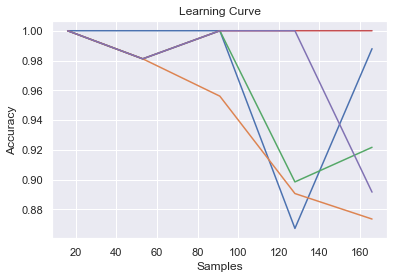

In [73]:
from sklearn.model_selection import learning_curve

cv = 5

curve = learning_curve(gnb, X_train, y_train,  cv=cv, verbose=3, n_jobs=-1, shuffle=False)

axs = plt.plot(curve[0], curve[1])
plt.title(f'Learning Curve for {cv} K-Fold Folders')
plt.ylabel('Accuracy')
plt.xlabel('Samples')
plt.show()

Note: Unexpectedly, the accuracy for each of the splits' test folders increased as the number of training samples decreased. Choose the appropriate number of training samples on the cell below based on the chart above.

---
## Image Classification Model Evaluation

#### Train and test split of image samples

In [74]:
t_size = 0.1
e_size = 0.6

X_train, X_test, y_train, y_test = train_test_split(
    X_res, Y_res, train_size=t_size, test_size=e_size,
    random_state=random_state, shuffle=True, stratify=Y_res
)

split_class_count(y_train, y_test)

,Train set,Test set
normalidade,52,314
acúmulo,52,313


#### Fit, predict and score base image classifier

In [75]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report

gnb = GaussianNB()

y_pred = gnb.fit(X_train, y_train).predict(X_test)

print("Number of mislabeled points out of a total of %d points : %d\n"
      % (X_test.shape[0], (y_test != y_pred).sum()))

print(classification_report(y_test, y_pred))

Number of mislabeled points out of a total of 627 points : 22

              precision    recall  f1-score   support

     acúmulo       1.00      0.93      0.96       313
 normalidade       0.94      1.00      0.97       314

    accuracy                           0.96       627
   macro avg       0.97      0.96      0.96       627
weighted avg       0.97      0.96      0.96       627



#### Save base model for camera code 1475

In [77]:
import pickle

model = gnb
filename = 'code1475.sav'

pickle.dump(model, open(filename, 'wb')) # save the model to disk

#### Display mislabeled images

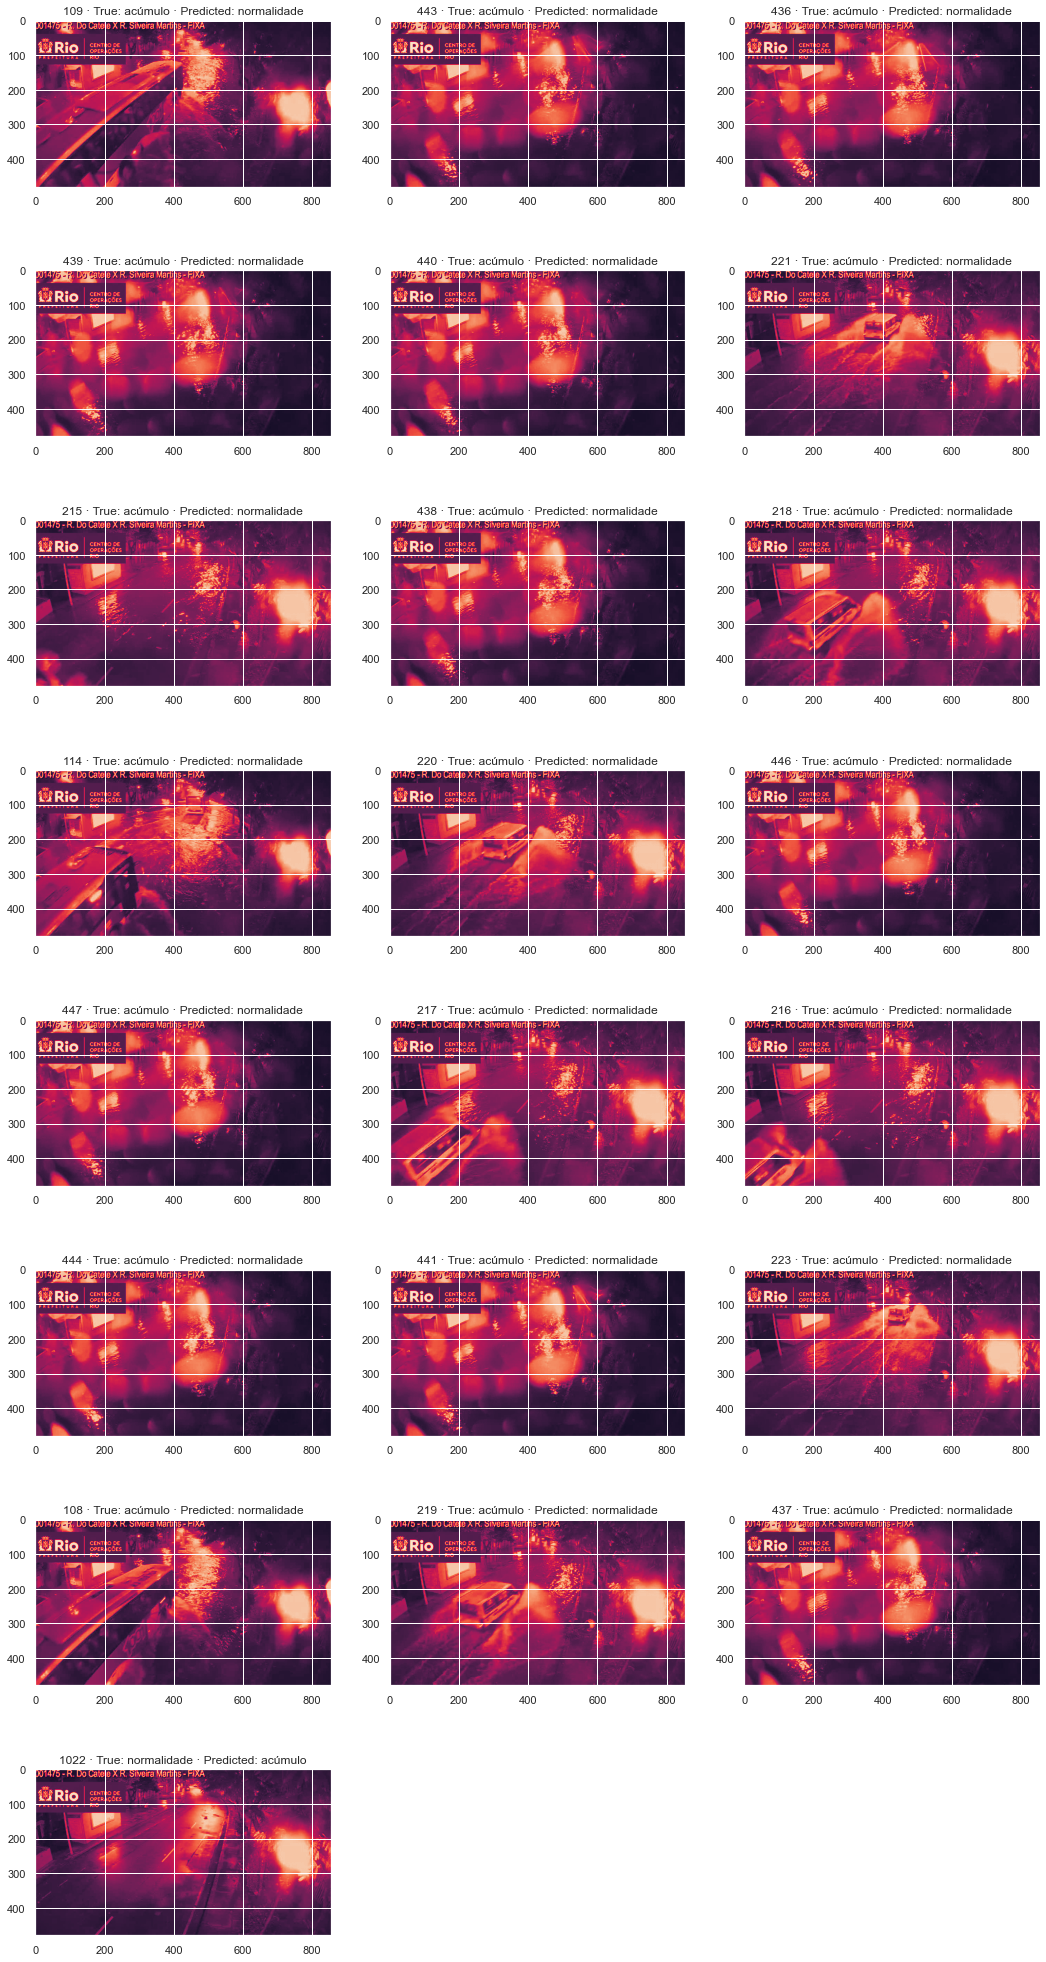

In [71]:
display_max = 22
random = True
n_cols = 3

display_mislabeled_images(X_test, y_test, y_pred, display_max, random, n_cols=n_cols)

---
## Predict entire dataset · Real Conditions Simulation

#### Optional · Train and test split of video samples

In [100]:
from sklearn.model_selection import train_test_split

t_size = 0.25
e_size = 0.25

# X, Y = x_res, y_res  # pre-sampled
X, Y = videos, y_true  # complete set of videos

xt, xe, yt, ye = train_test_split(
    X, Y, test_size=e_size, train_size=t_size,
    random_state=random_state, shuffle=True, stratify=Y
)

# complete x and y sequences
yy = pd.concat([yt, ye], axis=0)
xx = pd.concat([xt, xe], axis=0)

split_class_count(yt, ye)
display(yy.value_counts().to_frame('Complete set'))

,Train set,Test set
normalidade,31,32
acúmulo,9,9


,Complete set
normalidade,63
acúmulo,18


#### Load images and class labels from selected videos

In [101]:
folder = 'Dados/flood-video-collection'

XX, YY = xx, yy  # pre-sampled from loaded videos dataset
# XX, YY = videos, y_true  # complete set of frames from loaded videos dataset

videos_paths = [f'{folder}/{blob_name}'.replace(':', '-') for blob_name in XX['blob_name']]
videos_labels = YY.tolist()

video_loader = FrameLoader(dim=1)
frames, labels = video_loader.frames_from_labeled_videos(videos_paths, videos_labels, print_each=1)

print(f'\nVideos Selected: {len(XX)}')
print(f'Frames Loaded: {len(frames)}')
print(f'Length of frame first dimension: {len(frames[0])}')
print()

display(pd.Series(labels).value_counts().to_frame('Image Samples'))

CAPTURE LABELED VIDEOS · OPEN: 81/81

Videos Selected: 81
Frames Loaded: 2692
Length of frame first dimension: 409920



,Image Samples
normalidade,2150
acúmulo,542
